In [1]:
%pylab inline
from sympy.integrals.quadrature import gauss_lobatto

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.special import spherical_jn

In [3]:
def egvalred(a,Vcut):
    #remove high eigenvalues (>Vcut) from matrix 
    e,v=linalg.eig(a)
    ec=array(e)
    ec[abs(ec) > Vcut] = Vcut
    b=v.dot(diag(ec).dot(inv(v)))
    return b


In [4]:
class GLQuadrature:
    #costruct gauss_lobatto quadrature grid and derivative matrix
    def __init__(self,n=15):
        x, w = gauss_lobatto(n,15)
        self.x=array(x).astype(float)
        self.w=array(w).astype(float)
        self.n = n
        self.gldmat=self.Derivative()
        
    def Derivative(self):
        #calcualte (one elment [-1,1]) GaussLobatto derivative matrix
        dmat=array([array(zeros(self.n)) for i in range(self.n)])
        for i in range(self.n):
            for j in range(self.n):
                if i!=j:
                    pr=1./(self.x[j]-self.x[i])
                    dmat[i,i]-=pr
                    for k in range(self.n):
                        if (k!=i)and(k!=j):
                            pr*=(self.x[i]-self.x[k])/(self.x[j]-self.x[k])
                    dmat[i,j]+=pr
    
        return dmat
    
        
    def Info(self):
        print ("quadrature order=", self.n)
        
    def Rescale(self,a,b):
        x=(self.x+1.)*(b-a)/(2.)+a
        w=self.w*(b-a)/2.
        return (x,w)
  

In [5]:
class FEMDVR(GLQuadrature):
    #costruct FEMDVR basis from gauss_lobatto quadrature grid (and derivative matrices)
    def __init__(self,fe=[0.,1.,2.],n=5,Vcut=0.):
        GLQuadrature.__init__(self, n=n)
        self.fe=array(fe)
        self.xa,self.wa=self.ConstructFEMDVRgrid()
        self.xz,self.wz=self.xa[1:-1],self.wa[1:-1]
        self.d1matrix,self.d2matrix=self.Getdmat(Vcut=Vcut)
        
    def Info(self):
        GLQuadrature.Info(self)
        print ("        fem grid=", self.fe)
        
        
    def ConstructFEMDVRgrid(self):
        #construct FEM-DVR grid and wights: fe=FEM grid; n=DVR order 
        xa=array([])
        wa=array([])
        wafin=0.
        for i in range(1,len(self.fe)):
            x,w=GLQuadrature.Rescale(self,a=self.fe[i-1],b=self.fe[i])
            w[0]+=wafin
            if(i!=len(self.fe)-1):
                xa=append(xa,x[:-1])
                wa=append(wa,w[:-1])
            else:
                xa=append(xa,x)
                wa=append(wa,w)
            wafin=w[-1]

        return (xa,wa)
    
    
    def Getdmat(self,Vcut=0.):
        nbas=len(self.xz)
        dmat=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        dmat2=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        ntot=len(self.xa)
            
        xi=array(range(ntot))
        b=[]
        for i in range(len(self.fe)-1):
            b.append(xi[-self.n:])
            xi=xi[0:-self.n+1]

        b=array(list(reversed(b)))
        dmatx=array(self.gldmat).astype(complex)
    
        for l in range(len(b)):
            if l==0:
                bb=b[l,1:]
            elif l==len(b)-1:
                bb=b[l,:-1]
            else:
                bb=b[l]
            #print bb#
            for ii in bb:
                i=where( b[l]==ii )[0]
                for jj in bb:
                    j=where( b[l]==jj )[0]
                    de=dmatx[i,j]/(self.fe[l+1]-self.fe[l])*2.*sqrt(self.wa[ii]/self.wa[jj])
                    dmat[ii-1,jj-1]+=de[0]
                    #
                    de=0.
                    for m in range(self.n):
                        de+=dmatx[m,i]*dmatx[m,j]*2./(self.fe[l+1]-self.fe[l])*(self.w[m]/sqrt(self.wa[ii]*self.wa[jj]))
                    dmat2[ii-1,jj-1]-=de[0]
                    #

        for ii in range(self.n-2,len(dmat),self.n-1):
            dmat[ii,:]*=0.5

        if (Vcut != 0.):
            print ("Vcut=",Vcut)
            dmat2=egvalred(dmat2,Vcut)
                
        return (dmat,dmat2) 

 
        
    def FEMDVReval(self,x,k):
        #evaluate FEM-DVR basis functions at any point
        if(x<min(self.fe) or x>max(self.fe)):
            return 0.
        if(k<0 or x>len(self.xa)-1):
            return 0.
            
        ntot=len(self.xa)
        xi=array(range(ntot))
        #print (xi) #
        b=[]
        for i in range(len(self.fe)-1):
            b.append(xi[-self.n:])
            xi=xi[0:-self.n+1]

        b=array(list(reversed(b)))
        #print (b) #

        res=0.
        for bb in enumerate(b):
            if k in  list(bb)[1]:
                xmin=self.xa[list(bb)[1][0]]
                xmax=self.xa[list(bb)[1][-1]]
                if(x>=xmin and x<= xmax):
                    t=1.
                    for i in list(bb)[1]:
                        if (i!=k):
                            t=t*(x-self.xa[i])/(self.xa[k]-self.xa[i])
                    res=res+t
        return res
    
    def FEMDVRevalvec(self,x,v):
        #evaluate FEM-DVR basis for the whole vector
        res=0.
        for k in range(len(self.xz)):
            res+=self.FEMDVReval(x,k+1)*v[k]/sqrt(self.wz[k])
        return res
                

In [6]:
class ScatHamiltonian(FEMDVR):
    #costruct Hamiltonian for Hydrogen-like atom using FEMDVR basis
    def __init__(self,l,V,fe=[0.,5.,10.,20.,30.,40.,50.],n=15,zz=1.,nECS=-1,phiECS=pi/4.,Vcut=0.):
        self.nECS=nECS
        self.zz=zz
        self.phiECS=phiECS

        rECS=fe[nECS]
        feECS=array(fe).astype(complex)
        feECS[nECS:]=rECS + exp(1.j*phiECS)*(feECS[nECS:]-rECS)
        fe=feECS
        
        FEMDVR.__init__(self,fe=fe, n=n,Vcut=Vcut)
        self.hamiltonian=self.ConstructVX(l,V)
    
    def ConstructVX(self,l,V):

        hamiltonian=-0.5*self.d2matrix
        for ii in range(len(hamiltonian)):
            hamiltonian[ii,ii]=hamiltonian[ii,ii]+V(self.xz[ii])+0.5*l*(l+1.)/self.xz[ii]**2
        return hamiltonian


In [7]:
def scalpot_3D(x,pos=0):
    s2  = (1.2741)**2;
    Vp  = 0.07349864;
    lam = 10.0;
    Vs = Vp * exp(-norm(x-pos)/lam) / sqrt(norm(x-pos)**2 + s2);
    return (Vs)

# def scalHS_3D(x,pos=0):
#     Vp  = -10.;
#     a = .5;
#     if (x > a):
#         Vp=0.
#     return (Vp)

# def scalGBG_3D(x,pos=0):
#     Vp  = exp(-x)
#     return (Vp)

# def yukawa(x,d=1.):
#     Vp=exp(-x/d)/x
#     return(Vp)

# def Upolar(r,d=1.,U0=-250):
#     Vp=U0/(r**2+d**2)*2
#     return(Vp)

# def nopot(r):
#     return(0.)

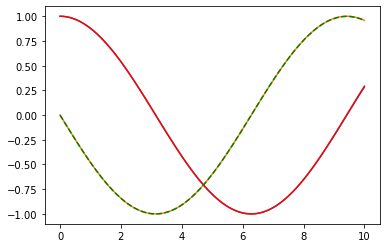

In [8]:
import scipy.integrate as integrate
from scipy.special import sph_harm
from scipy.special import jv


l=2
k=0.5
theta=pi
r=linspace(0.0001,10,100)
pw=exp(1.j*k*r*cos(theta))
plot(r,real(pw),"-")
plot(r,imag(pw),"-")
# show()


y=zeros(len(r))
ll=arange(10)
for l in ll:
    rv=array([integrate.quad(lambda t: real(sph_harm(0,l,0.,t)*sin(t)*exp(1.j*rr*k*cos(t))), 0, pi)[0]*2*pi for rr in r])
    iv=array([integrate.quad(lambda t: imag(sph_harm(0,l,0.,t)*sin(t)*exp(1.j*rr*k*cos(t))), 0, pi)[0]*2*pi for rr in r])
    res=rv+1.j*iv
    y=y+res*sph_harm(0,l,0.,theta)
    
plot(r,real(y),"r-")
plot(r,imag(y),"g--")

In [9]:
# l=4
# rv=array([integrate.quad(lambda t: real(sph_harm(0,l,0.,t)*sin(t)*exp(1.j*rr*k*cos(t))), 0, pi)[0]*2*pi for rr in r])
# iv=array([integrate.quad(lambda t: imag(sph_harm(0,l,0.,t)*sin(t)*exp(1.j*rr*k*cos(t))), 0, pi)[0]*2*pi for rr in r])
# res=rv+1.j*iv

# plot(r,real(res),"r-")
# plot(r,imag(res),"g--")


# res2=2*sqrt(pi*(2*l+1))*(1.j)**l*spherical_jn(l,k*r)
# plot(r,real(res2),"r.")
# plot(r,imag(res2),"g.")


In [10]:
import scipy.integrate as integrate
from scipy.special import sph_harm


#construct finite elemements
fe=arange(0,100,5).astype(float)
fe=append(fe,fe[-1]+50)
#construct scattering Hamiltonian using default DVR

lmax=50
ll=arange(lmax)
V=scalpot_3D
#energy=linspace(0.01,.2,50)
energy=array([0.0569541043*i-0.5 for i in [15,16,17]])  #scatt. energies from bands 15,16 and 17
fk=[]


for l in ll:
    hmt=ScatHamiltonian(fe=fe,l=l,V=V,nECS=-4,zz=1,phiECS=deg2rad(30))
    nrel=len(where(imag(hmt.xz)==0)[0])
    
    farr=[]
    for e in energy:
        k=sqrt(2.*e)  
        res=2*sqrt(pi*(2*l+1))*(1.j)**l*spherical_jn(l,k*real(hmt.xz))
        t1=res*sqrt(2./k)*hmt.xz*sqrt(hmt.wz)
        t1[imag(hmt.xz)!=0.]=0.
        phi0=t1
        
        rhs=array([scalpot_3D(xx) for xx in real(hmt.xz)])*phi0
        A=identity(len(hmt.xz))*e-hmt.hamiltonian
        phisw=numpy.linalg.solve(A, rhs)
        Surf=hmt.d1matrix.dot(conjugate(phisw))*phi0-conjugate(phisw)*hmt.d1matrix.dot(phi0)
        f=2*pi*(Surf/hmt.wz)[nrel-20]
        farr.append(f)
    farr=array(farr)
    fk.append(farr)
fk=array(fk)

Text(0, 0.5, '${\\sigma}$ [a.u.]')

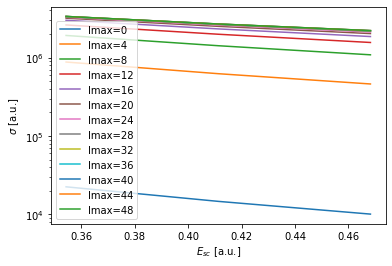

In [11]:
#total cross section \sigma
yscale("log")
for lcut in ll[0::4]:
    plot(energy,4*pi*sum(abs(fk[0:lcut+1])**2,axis=0),"-",label="lmax="+str(lcut))
legend()
xlabel(r"$E_{sc}$ [a.u.]")
ylabel(r"${\sigma}$ [a.u.]")

Text(0, 0.5, '${d\\sigma}/{d\\Omega}(\\theta=0)$ [a.u.]')

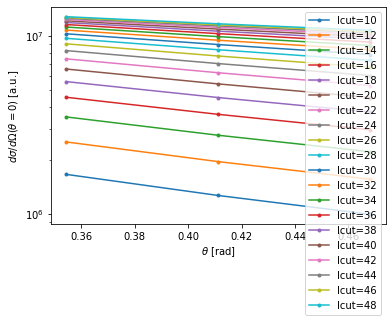

In [12]:
from scipy.special import sph_harm
#total cross section \sigma in \theta=0 direction
yscale("log")
for lcut in ll[10::2]:
    theta=0.
    sph=array([sph_harm(0,l,0.,theta) for l in arange(lcut+1)])
    plot(energy,abs(sum(fk[0:lcut+1].transpose()*sph,axis=1))**2,".-",label="lcut="+str(lcut))
legend()
xlabel(r"$\theta$ [rad]")
ylabel(r"${d\sigma}/{d\Omega}(\theta=0)$ [a.u.]")


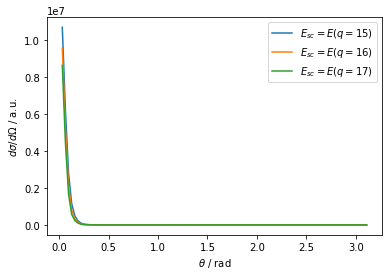

In [18]:
theta=linspace(0,pi,100)
theta=theta[1:-1]
a=zeros((len(theta),len(energy)))

# yscale("log")

lcut=ll[-1]
for j,t in enumerate(theta):
    sph=array([sph_harm(0,l,0.,t) for l in arange(lcut+1)])
    x=abs(sum(fk[0:lcut+1].transpose()*sph,axis=1))**2
    a[j,:]=x
    

for i,e in enumerate(energy):
    #plot(theta,a[:,i]/a[0,i]*(sin(theta)),label=r"$E_{sc}=$"+str(e)[:7])
    #plot(theta,a[:,i],label=r"$E_{sc}=$"+str(e)[:7])
    plot(theta,a[:,i],label=r"$E_{sc}=E(q="+str(i+15)+")$")
xlabel(r"$\theta$ / rad")
ylabel(r"${d\sigma}/{d\Omega}$ / a.u.")
legend()
# savefig('/home/d/Scratch/3Dpaper/figures/elsticDCS.eps')

In [14]:
head="theta/rad             "
for e in energy:
    head=head+" DCS(E="+str(e)[:10]+")/a.u.  "
tdcs=append(array([theta]),a.transpose(), axis=0).transpose()
savetxt("yukaw_DCS.txt",tdcs,header=head)

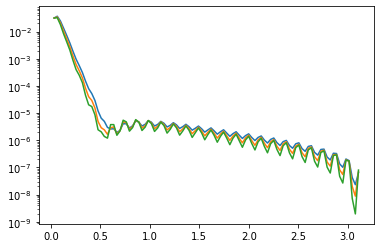

In [15]:
yscale("log")
for i,e in enumerate(energy):
    plot(theta,a[:,i]/a[0,i]*(sin(theta)),label=r"$E_{sc}=$"+str(e)[:7])
    #plot(theta,a[:,i],label=r"$E_{sc}=$"+str(e)[:7])
